## Brain Traumatic Detection

Full analysis of EEG signals.

1. Preprocessing
    * Artifacts removal
3. Feature engineering
4. Model training
5. Testing

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from utils import get_extracts, plot_rawsignal
from utils import calc_features

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(font_scale=1.2)
# sns.set_style(style='white') 

### 1. Preprocessing

Dataset is in edf format, so first we convert to csv format

From .dft to .csv using the following command

`python chmt_preproc/main.py --data-path raw_data/ --out-path preproc_data`

In [2]:
# Summary of conversion
data_pre = pd.read_csv('preproc_data/preprocessed.csv')

**Artifact removal**
During the conversion(from edf to csv) step were removed two artifacts: hearth and eye movements. 
More on this check `Artifacts.ipynb`

In addition to the data homogenisation, we also removed bad signals in the followoing section

In [3]:
fns = data_pre['fn']
targets = data_pre['target']
sfreqs = data_pre['sfreq']

records, targets, subjects = get_extracts(fns, targets, sfreqs)

In [4]:
# Preprocessed information 
new_data = pd.DataFrame(zip(subjects, targets), columns=['fn','target'])
new_data.to_csv('preproc_data/processed.csv', index=False)

In [8]:
print('Summary of preprocessed dataset:')
print('* Shape of data:', new_data.shape)
print('\n* Number of subjects per group: \n', new_data.target.value_counts())

Summary of preprocessed dataset:
* Shape of data: (185, 2)

* Number of subjects per group: 
 healthy    134
trauma      51
Name: target, dtype: int64


### 2. Feature engineering

Features generated based on coherence for alpha, beta, and whole bands, envelope for alpha, beta, and whole band and spectral density (PSD)

In [8]:
import time

method_list=['coh','coh_alpha', 'coh_beta', 'env','env_alpha','env_beta', 'bands']

for m in method_list:
    print('Started features stage -', m)
    time.sleep(1)
    genFeatures(m, 'preproc_data', 'processed.csv', 'ml_data') 

Started features stage - coh


100%|██████████| 185/185 [00:59<00:00,  3.14it/s]


Started features stage - coh-alpha


100%|██████████| 185/185 [01:02<00:00,  2.96it/s]


Started features stage - coh-beta


100%|██████████| 185/185 [01:02<00:00,  2.98it/s]


Started features stage - env


100%|██████████| 185/185 [00:16<00:00, 11.28it/s]


Started features stage - env-alpha


100%|██████████| 185/185 [00:17<00:00, 10.56it/s]


Started features stage - env-beta


100%|██████████| 185/185 [00:16<00:00, 10.94it/s]


Started features stage - bands


100%|██████████| 185/185 [00:22<00:00,  8.16it/s]


Concatenating all features 

In [10]:
for i, m in enumerate(method_list):
    m = m.replace('-','_')
    if i == 0:
        data = pd.read_csv('ml_data/{}.csv'.format(m))
    else:
        sub = pd.read_csv('ml_data/{}.csv'.format(m))
        data = pd.concat([data, sub], axis=1)

data = data.loc[:,~data.columns.duplicated()]
data.to_csv('ml_data/allfeatures.csv', index=False)

**Select features correlated with target**

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [12]:
data['target'] = data['target'].apply(lambda x: 0 if x=='healthy' else 1 if x=='trauma' else None)
X = data.drop(['fn','target'], axis=1)
y = data.target

In [13]:
data.shape

(185, 886)

In [15]:
rfc = RandomForestClassifier(random_state=101, class_weight='balanced')
kfold = StratifiedKFold(n_splits=5, shuffle=True) 
cv = kfold.split(X, y)
rfecv = RFECV(estimator=rfc, step=10, min_features_to_select=20, cv=cv)
rfecv.fit(X, y)

RFECV(cv=<generator object _BaseKFold.split at 0x7fd4499b5150>,
      estimator=RandomForestClassifier(class_weight='balanced',
                                       random_state=101),
      min_features_to_select=20, step=10)

In [16]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 44


**Features most correlated with target**

In [17]:
X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)

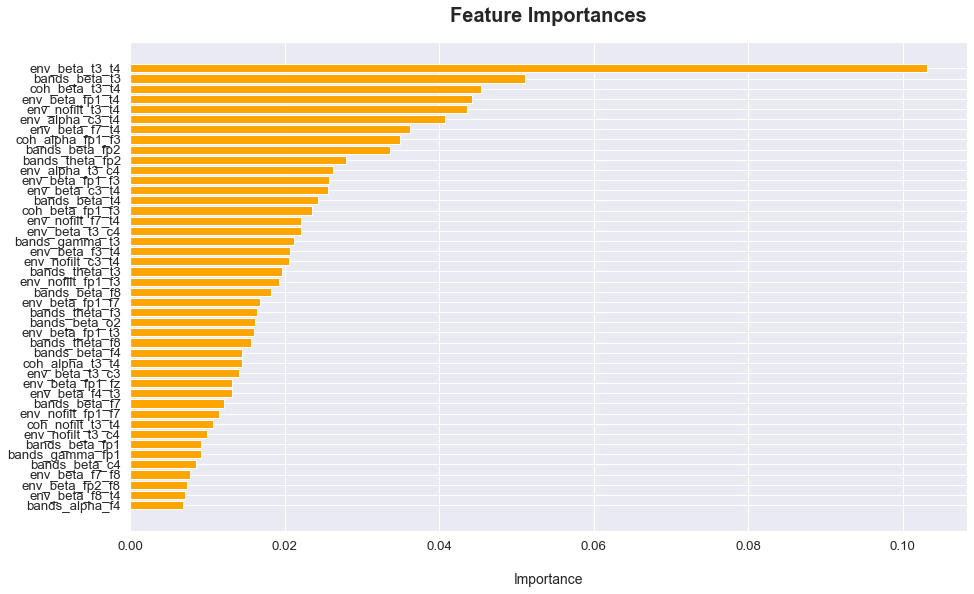

In [18]:
dset = pd.DataFrame()

dset['attr'] = X2.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=True)
plt.figure(figsize=(15, 9))
plt.barh(y=dset['attr'], width=dset['importance'], color='orange')
plt.title('Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [19]:
# Save only selected features

X2[['fn','target']] = data[['fn','target']]
X2.to_csv('ml_data/featuresML.csv', index=False)

### 3. Model training

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [10]:
data = pd.read_csv('ml_data/featuresML.csv')

In [11]:
X = data.drop(['fn','target'], axis=1)
y = data.target

In [16]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

**Data normalization**

In [17]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

**Random Forest**

In [18]:
grid={'n_estimators':[10, 100, 300, 500], 'max_features': ['auto', 'sqrt', 'log2'],"class_weight":['none','balanced']}

rdf=RandomForestClassifier()

rdf_cv=GridSearchCV(rdf,grid,cv=10, n_jobs=-1)
rdf_cv.fit(X_train_sc,y_train)

print("tuned hpyerparameters :(best parameters) ",rdf_cv.best_params_)
print("accuracy :",rdf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 100}
accuracy : 0.9217948717948719


In [19]:
## Cross validation
scores = cross_val_score(rdf, X_train_sc, y_train, cv=5)

In [20]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.10)


**Logisict Regression**

In [23]:
clf = LogisticRegression()
clf.fit(X_train_sc, y_train)

scores = cross_val_score(clf, X_train_sc, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.10)


### 4. Testing

**Random forest (only hearth artifact removed)**

In [27]:
y_pred = rdf_cv.predict(X_test_sc)
acc = accuracy_score(y_test, y_pred)
print('Test accuracy: ', acc)

Test accuracy:  0.9107142857142857


<AxesSubplot:ylabel='count'>

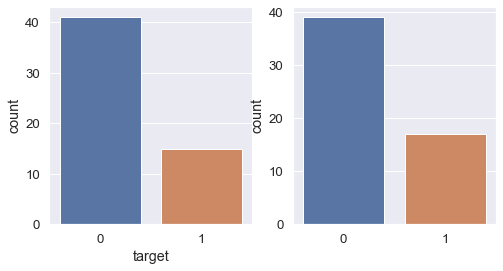

In [60]:
fig, axs = plt.subplots(1,2, figsize=[8,4])
sns.countplot(y_test, ax=axs[0])
sns.countplot(y_pred, ax=axs[1])

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        41
           1       0.71      0.80      0.75        15

    accuracy                           0.86        56
   macro avg       0.81      0.84      0.83        56
weighted avg       0.86      0.86      0.86        56



**Random forest (eye and hearth artifacts removed)**

<AxesSubplot:ylabel='count'>

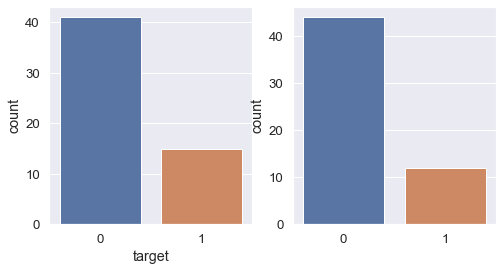

In [28]:
fig, axs = plt.subplots(1,2, figsize=[8,4])
sns.countplot(y_test, ax=axs[0])
sns.countplot(y_pred, ax=axs[1])

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        41
           1       0.92      0.73      0.81        15

    accuracy                           0.91        56
   macro avg       0.91      0.85      0.88        56
weighted avg       0.91      0.91      0.91        56



**Logistic Regression**

In [30]:
y_pred = clf.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        41
           1       0.85      0.73      0.79        15

    accuracy                           0.89        56
   macro avg       0.88      0.84      0.86        56
weighted avg       0.89      0.89      0.89        56



<AxesSubplot:ylabel='count'>

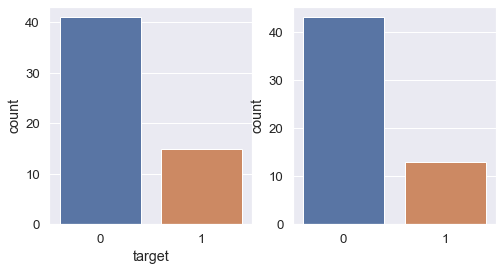

In [31]:
fig, axs = plt.subplots(1,2, figsize=[8,4])
sns.countplot(y_test, ax=axs[0])
sns.countplot(y_pred, ax=axs[1])